In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import colorcet as cc
import plotly.express as px

from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)
%matplotlib inline

config = {
  'toImageButtonOptions': {
    'format': 'png', # one of png, svg, jpeg, webp
    'filename': 'newplot',
    'height': 500,
    'width': 900,
    'scale': 5 # Multiply title/legend/axis/canvas sizes by this factor
  }
}

In [3]:
df=pd.read_pickle('./dataset_/dataset_cleaned_popularity.pkl')
df.drop(columns=['index', 'level_0'], inplace=True)  # Comes from pickeling the file
df.reset_index(drop=True, inplace=True)

In [4]:
df['popularity'].describe()

count    166681.000000
mean       5511.366120
std       13236.831027
min           0.800000
25%          78.400000
50%         530.400000
75%        3995.050000
max      233766.900000
Name: popularity, dtype: float64

## Popularity Prediction
This week, we started to work on our predictive mining tasks, one of them is song popularity prediction. By the end of this project, we hope that we can see what is the typical song that is getting more popular than the others in Spotify. We got two ideas in mind, which are popularity score prediction and popularity classification (popular / not popular).

### Data Pre-processing
Before jump into the main modelling task, here we'll process all of our our possible features based on its data type:

**Numerical Features**
* popularity
* artist_followers
* danceability
* energy
* loudness
* speechiness
* acoustics
* instrumentalness
* liveness
* valence
* duration_min

**Categorical Features**
* explicit
* key
* mode
* release_day

For the first round selection, we selected the features based on our knowledge and common sense, later we'll try to fit in all these features into some models first and see how they perform.
#### Popularity
The original value of our popularity score is the calculation of number of days and position they stayed in the Top 200 Playlist and the score is also difference for each country.

In [5]:
df.sort_values(by='popularity', ascending=False).head(5)[['country', 'artist', 'title', 'album', 'popularity']]

,country,artist,title,album,popularity
52226,Belgium,Ed Sheeran,shape of you,÷ (Deluxe),233766.9
52232,Costa Rica,Ed Sheeran,shape of you,÷ (Deluxe),228707.2
52220,Global,Ed Sheeran,shape of you,÷ (Deluxe),221571.0
30287,Philippines,James Arthur,say you wont let go,Back from the Edge,217605.8
52252,Singapore,Ed Sheeran,shape of you,÷ (Deluxe),217307.4


As you can see in the table, there are multiple countries that have "Shape of You" as their top popular song, and this also means that this song is very popular compared to a song that only appears in one coutnry top playlist, right?

So, in order to get a unique song popularity score, we decided to sum up the every country's popularity score for each song, since the higher value they got, means the more popular they are.

In [6]:
df = df.groupby(['title', 'artist', 'release_type', 'sub_genre', 'artist_followers', 'explicit', 'album', 'track_number', 'tracks_in_album', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acoustics', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'genre', 'duration_min', 'release_year', 'release_month', 'release_day'])['popularity'].sum().reset_index(name='popularity')
df.sort_values(by='popularity', ascending=False).head(5)[['artist', 'title', 'album', 'popularity']]

,artist,title,album,popularity
44367,Ed Sheeran,shape of you,÷ (Deluxe),5732932.35
11089,Tones And I,dance monkey,Dance Monkey,3624590.65
38669,Ed Sheeran,perfect,÷ (Deluxe),2933691.50
4480,Billie Eilish,bad guy,"WHEN WE ALL FALL ASLEEP, WHERE DO WE GO?",2812179.25
44341,Lady Gaga - Bradley Cooper,shallow,A Star Is Born Soundtrack,2600171.85


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59492 entries, 0 to 59491
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   title             59492 non-null  object 
 1   artist            59492 non-null  object 
 2   release_type      59492 non-null  object 
 3   sub_genre         59492 non-null  object 
 4   artist_followers  59492 non-null  float64
 5   explicit          59492 non-null  object 
 6   album             59492 non-null  object 
 7   track_number      59492 non-null  object 
 8   tracks_in_album   59492 non-null  object 
 9   danceability      59492 non-null  float64
 10  energy            59492 non-null  float64
 11  key               59492 non-null  object 
 12  loudness          59492 non-null  float64
 13  mode              59492 non-null  object 
 14  speechiness       59492 non-null  float64
 15  acoustics         59492 non-null  float64
 16  instrumentalness  59492 non-null  float6

As a result, we got 59,492 unique songs.

The mean is way too shifted to the left, even from 59k songs, 51k songs are below average, because the dataset has a few extreme popular songs. But it's not possible to enrich the data again, because the calculation of popularity in our dataset is different between the Spotify one. Consequently, we'll work on the data as it is.

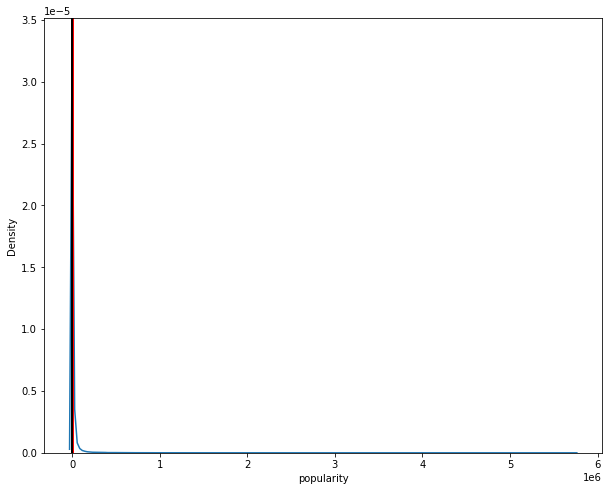

In [8]:
plt.figure(figsize=(10, 8))
sns.kdeplot(df['popularity'])

plt.axvline(df['popularity'].mean(), linewidth = 2, color = 'r')
plt.axvline(df['popularity'].median(), linewidth = 2, color = 'k')
plt.show()

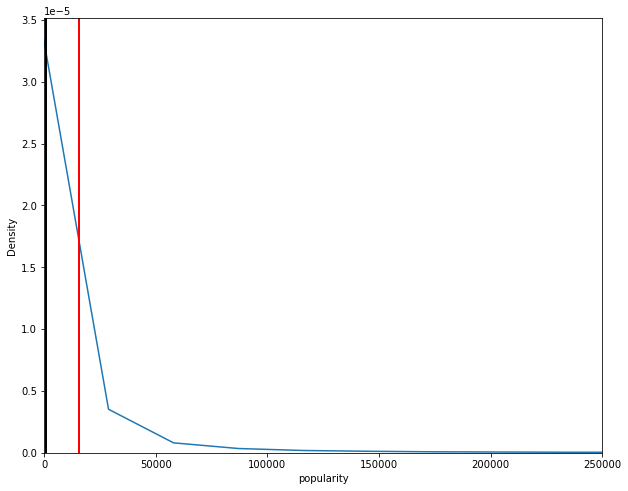

In [14]:
plt.figure(figsize=(10, 8))
sns.kdeplot(df['popularity'])

plt.axvline(df['popularity'].mean(), linewidth = 2, color = 'r')
plt.axvline(df['popularity'].median(), linewidth = 2, color = 'k')
plt.xlim(0, 250000)
plt.show()

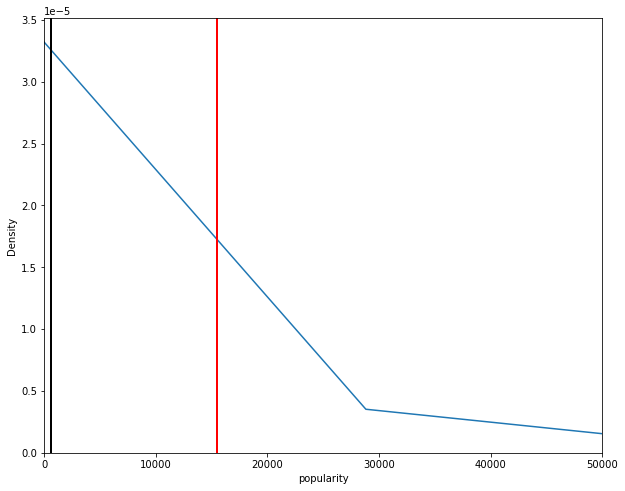

In [15]:
plt.figure(figsize=(10, 8))
sns.kdeplot(df['popularity'])

plt.axvline(df['popularity'].mean(), linewidth = 2, color = 'r')
plt.axvline(df['popularity'].median(), linewidth = 2, color = 'k')
plt.xlim(0, 50000)
plt.show()

In [9]:
df['popularity'].describe()

count    5.949200e+04
mean     1.544140e+04
std      8.828579e+04
min      8.000000e-01
25%      9.360000e+01
50%      6.093000e+02
75%      4.694288e+03
max      5.732932e+06
Name: popularity, dtype: float64

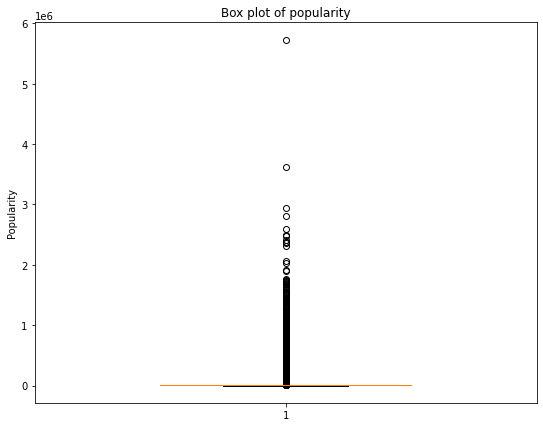

In [17]:
fig = plt.figure(figsize=(9,7))
plt.boxplot([df['popularity']], widths=0.5)
plt.ylabel('Popularity')
plt.title('Box plot of popularity')
plt.show()

In [30]:
minvalue,mean,median,q25,q75,maxvalue = np.round_(df['popularity'].min(), decimals=2), np.round_(df['popularity'].mean(), decimals=2), np.round_(df['popularity'].median(), decimals=2), np.round_(np.percentile(df['popularity'],25), decimals=2), np.round_(np.percentile(df['popularity'],75), decimals=2), np.round_(df['popularity'].max(), decimals=2)

In [31]:
popularity_stats = pd.DataFrame(data=[["Popularity", minvalue, mean, q25, median, q75, maxvalue]], 
                          columns=['Column', 'Min', 'Mean', '25%', '50%', '75%', "Max"])
popularity_stats

,Column,Min,Mean,25%,50%,75%,Max
0,Popularity,0.8,15441.4,93.6,609.3,4694.29,5732932.35


After that, we checked again which feature is needed to be processed.

In [32]:
df.nunique(axis=0)

title               44954
artist              23360
release_type            3
sub_genre            1119
artist_followers     9134
explicit                4
album               32653
track_number           73
tracks_in_album       136
danceability          990
energy               1225
key                    24
loudness            12259
mode                    4
speechiness          1512
acoustics            3551
instrumentalness     5061
liveness             1727
valence              1543
tempo               30613
time_signature          9
genre                  21
duration_min        36712
release_year           79
release_month          12
release_day            31
popularity          36178
dtype: int64

From the result above, you can see that explicit and mode is supposed to have only binary value, but there is 4 unique values instead.

#### Explicit
We will change the string value of "True" and "False" into a boolean one.

In [33]:
df['explicit'].unique()

array([False, True, 'True', 'False'], dtype=object)

In [34]:
df.loc[df.explicit == 'True', 'explicit'] = 1
df.loc[df.explicit == 'False', 'explicit'] = 0
df.loc[df.explicit == True, 'explicit'] = 1
df.loc[df.explicit == False, 'explicit'] = 0

In [35]:
df['explicit'].unique()

array([0, 1], dtype=object)

#### Mode
We will change the string value of "0" and "1" into a numeric one.

In [36]:
df['mode'].unique()

array([1, 0, '1', '0'], dtype=object)

In [37]:
df.loc[df['mode'] == '0', 'mode'] = 0
df.loc[df['mode'] == '1', 'mode'] = 1

In [38]:
df['mode'].unique()

array([1, 0], dtype=object)

In [39]:
df.nunique(axis=0)

title               44954
artist              23360
release_type            3
sub_genre            1119
artist_followers     9134
explicit                2
album               32653
track_number           73
tracks_in_album       136
danceability          990
energy               1225
key                    24
loudness            12259
mode                    2
speechiness          1512
acoustics            3551
instrumentalness     5061
liveness             1727
valence              1543
tempo               30613
time_signature          9
genre                  21
duration_min        36712
release_year           79
release_month          12
release_day            31
popularity          36178
dtype: int64

#### Key
There are duplicated keys, so we tried to convert all of them into numeric values.

In [40]:
df['key'].unique()

array([1, 5, 8, 4, 11, 10, 9, 0, '1', 2, 7, 6, '9', '10', '0', 3, '5',
       '11', '4', '7', '2', '3', '6', '8'], dtype=object)

In [41]:
df.loc[df['key'] == '9', 'key'] = 9
df.loc[df['key'] == '10', 'key'] = 10
df.loc[df['key'] == '0', 'key'] = 0
df.loc[df['key'] == '5', 'key'] = 5
df.loc[df['key'] == '11', 'key'] = 11
df.loc[df['key'] == '4', 'key'] = 4
df.loc[df['key'] == '7', 'key'] = 7
df.loc[df['key'] == '2', 'key'] = 2
df.loc[df['key'] == '3', 'key'] = 3
df.loc[df['key'] == '6', 'key'] = 6
df.loc[df['key'] == '8', 'key'] = 8
df.loc[df['key'] == '1', 'key'] = 1

In [42]:
df['key'].unique()

array([1, 5, 8, 4, 11, 10, 9, 0, 2, 7, 6, 3], dtype=object)

#### Release Day

In [43]:
df['release_date'] = pd.to_datetime(df['release_year'].astype(str) + '-' + df['release_month'].astype(str) + '-' + df['release_day'].astype(str), errors='ignore')
df['weekday'] = df['release_date'].dt.dayofweek
df

,title,artist,release_type,sub_genre,artist_followers,explicit,album,track_number,tracks_in_album,danceability,energy,key,loudness,mode,speechiness,acoustics,instrumentalness,liveness,valence,tempo,time_signature,genre,duration_min,release_year,release_month,release_day,popularity,release_date,weekday
0,!,O.S.T.R.,album,polish hip hop,306856.0,0,W drodze po szczęście,1,15,0.561,0.798,1,-7.064,1,0.3200,0.3070,0.000000,0.1100,0.140,140.837,4,hip hop,3.696017,2018,2,26,866.00,2018-02-26,0
1,!,Trippie Redd,album,melodic rap,5502398.0,1,!,1,14,0.725,0.543,5,-6.311,1,0.0841,0.0296,0.000000,0.1770,0.693,119.961,4,rap,2.255650,2019,8,9,1818.55,2019-08-09,4
2,!ill be back!,Rilès,single,french hip hop,614607.0,1,!I'll Be Back!,1,1,0.823,0.612,1,-7.767,1,0.2480,0.1680,0.000000,0.1090,0.688,142.959,4,hip hop,2.975550,2018,6,22,49.60,2018-06-22,4
3,#%_! dig selv,Artigeardit,album,danish hip hop,19841.0,1,IDIOT,9,16,0.655,0.498,8,-7.297,1,0.2930,0.1250,0.000014,0.1660,0.241,94.146,4,hip hop,3.135650,2020,1,31,413.05,2020-01-31,4
4,#213,YL,album,francoton,617156.0,1,Vaillants,4,12,0.714,0.727,4,-6.216,0,0.4160,0.2000,0.000000,0.0879,0.497,190.567,3,indie,3.325150,2020,4,16,48.80,2020-04-16,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59487,쩔어 dope,BTS,album,k-pop,24755789.0,0,"화양연화 The Most Beautiful Moment In Life, Pt. 1",5,9,0.619,0.889,10,-3.108,0,0.2190,0.0483,0.000000,0.3240,0.622,77.058,4,k-pop,4.000350,2015,4,29,712.00,2015-04-29,2
59488,파란 봄,AILEE,single,k-pop,725478.0,0,"Dunia - Into A New World, Pt. 1 (Original Soun...",1,2,0.540,0.535,1,-4.860,1,0.0301,0.4590,0.000000,0.1540,0.216,131.990,3,k-pop,4.194717,2018,6,24,54.40,2018-06-24,6
59489,피 땀 눈물,BTS,album,k-pop,24755789.0,0,WINGS,2,15,0.583,0.885,0,-3.571,0,0.1060,0.0244,0.000000,0.3570,0.601,92.959,4,k-pop,3.617533,2016,10,10,287.20,2016-10-10,0
59490,항상,j-hope - Supreme Boi,album,k-pop,4486644.0,0,Hope World,5,7,0.832,0.896,6,-4.673,1,0.2330,0.1590,0.000048,0.2470,0.618,178.998,4,k-pop,3.827933,2018,3,2,862.30,2018-03-02,4


In [44]:
df['weekday'].unique()

array([0, 4, 3, 2, 1, 6, 5])

#### Drop Unused Columns

In [45]:
categorical_features = ["title", 
                        "artist", 
                        "sub_genre", 
                        "album", 
                        "track_number", 
                        "tracks_in_album", 
                        "time_signature", 
                        "genre"]

In [46]:
numeric_features = ['popularity', 'artist_followers', 'danceability', 'energy', 
                    'loudness', 'speechiness', 'acoustics', 'instrumentalness', 
                    'liveness', 'valence', 'tempo', 'duration_min']

In [47]:
df_selected = df[numeric_features]

In [48]:
df_selected.nunique(axis=0)

popularity          36178
artist_followers     9134
danceability          990
energy               1225
loudness            12259
speechiness          1512
acoustics            3551
instrumentalness     5061
liveness             1727
valence              1543
tempo               30613
duration_min        36712
dtype: int64

### Features Visualization
Here we wanted to recap on how all the features behave in popularity and for a better visualization, we will scale the popularity values first into a 0-100 range.

<Figure size 1080x720 with 0 Axes>

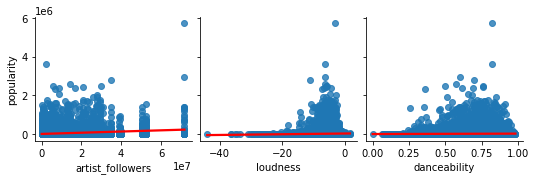

In [49]:
plt.figure(figsize=(15,10))
pp = sns.pairplot(data=df,
                  x_vars=['artist_followers', 'loudness', 'danceability'],
                  y_vars=['popularity'], kind="reg", plot_kws={'line_kws':{'color':'red'}})
plt.show()
# pp.savefig('numeric1.jpg', dpi=300, bbox_inches='tight')

<Figure size 1152x576 with 0 Axes>

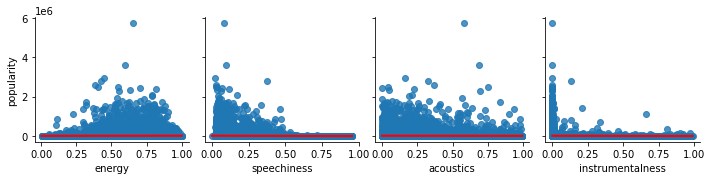

In [50]:
plt.figure(figsize=(16, 8))
pp = sns.pairplot(data=df,
                  x_vars=['energy', 'speechiness', 'acoustics', 'instrumentalness'],
                  y_vars=['popularity'], kind="reg", plot_kws={'line_kws':{'color':'red'}})
plt.show()
# pp.savefig('numeric2.jpg', dpi=300, bbox_inches='tight')

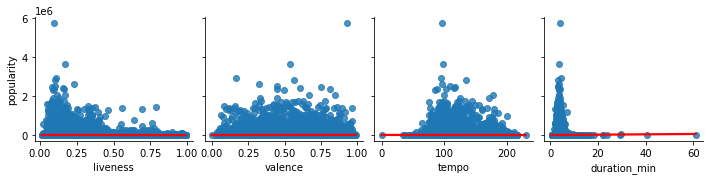

In [51]:
pp = sns.pairplot(data=df,
                  x_vars=['liveness', 'valence', 'tempo', 'duration_min'],
                  y_vars=['popularity'], kind="reg", plot_kws={'line_kws':{'color':'red'}})
# pp.savefig('numeric3.jpg', dpi=300, bbox_inches='tight')

### Modelling

In [52]:
y = df_selected['popularity']
X = df_selected.drop(["popularity"],axis=1)

#### 1. Linear Regression

First, we would like to see how our numerical features perform first.

In [53]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    print('__________________________________')
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square

def cross_val(model):
    pred = cross_val_score(model, X, y, cv=10)
    return pred.mean()

In [54]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression()
lm.fit(X_train, y_train)
train_pred = lm.predict(X_train)
test_pred = lm.predict(X_test)
val_pred = lm.predict(X_val)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)

print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

print('Validation set evaluation:\n_____________________________________')
print_evaluate(y_val, val_pred)

results_val_df = pd.DataFrame(data=[["Linear Regression", *evaluate(y_val, val_pred) , cross_val(LinearRegression())]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])

results_train_df = pd.DataFrame(data=[["Linear Regression", *evaluate(y_train, train_pred) , cross_val(LinearRegression())]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])

results_df = pd.DataFrame(data=[["Linear Regression", *evaluate(y_test, test_pred) , cross_val(LinearRegression())]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])

Test set evaluation:
_____________________________________
MAE: 22336.189666013437
MSE: 5798865956.591691
RMSE: 76150.28533493287
R2 Square 0.07742936982661597
__________________________________
Train set evaluation:
_____________________________________
MAE: 22814.022418494107
MSE: 7867412659.334883
RMSE: 88698.4366228339
R2 Square 0.05404497640185191
__________________________________
Validation set evaluation:
_____________________________________
MAE: 23063.239969974777
MSE: 7349733931.924028
RMSE: 85730.58924283694
R2 Square 0.049815551323180496
__________________________________


The lower value of MAE, MSE, and RMSE implies higher accuracy of a regression model. However, a higher value of R square is considered desirable.

R-squared is always between 0 and 100%:

- 0% represents a model that does not explain any of the variation in the response variable around its mean. The mean of the dependent variable predicts the dependent variable as well as the regression model.
- 100% represents a model that explains all the variation in the response variable around its mean.

So, if the R2 of a model is 0.50, then approximately half of the observed variation can be explained by the model’s inputs. And by our case, it's almost near zero, then the model doesn't represent the overall variance of the variables.

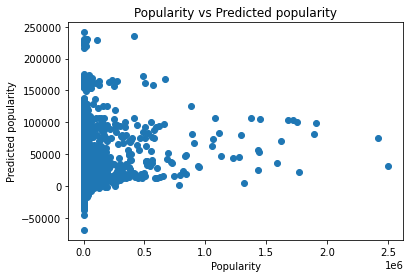

In [55]:
# VAL: Visualizing the differences between actual prices and predicted values
plt.scatter(y_val, val_pred)
plt.xlabel("Popularity")
plt.ylabel("Predicted popularity")
plt.title("Popularity vs Predicted popularity")
plt.show()

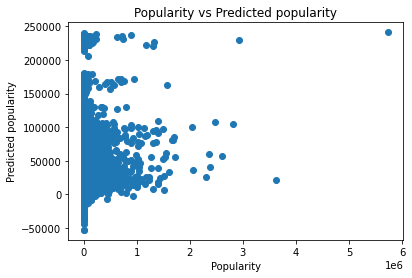

In [56]:
# TRAIN: Visualizing the differences between actual prices and predicted values

plt.scatter(y_train, train_pred)
plt.xlabel("Popularity")
plt.ylabel("Predicted popularity")
plt.title("Popularity vs Predicted popularity")
plt.show()
# plt.savefig('lm_popularity.jpg', dpi=300, bbox_inches='tight')

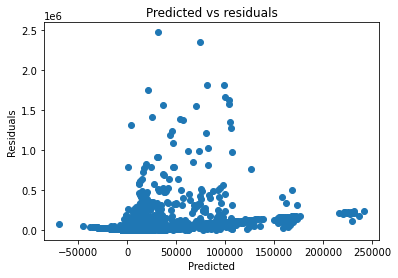

In [57]:
# Checking residuals
plt.scatter(val_pred,np.abs(y_val-val_pred))
plt.title("Predicted vs residuals")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.show()

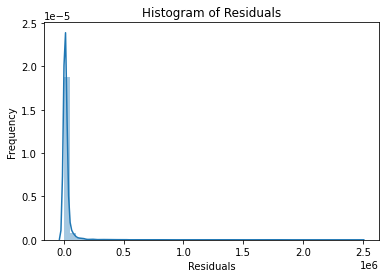

In [58]:
# Checking Normality of errors
sns.distplot(np.abs(y_val-val_pred))
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

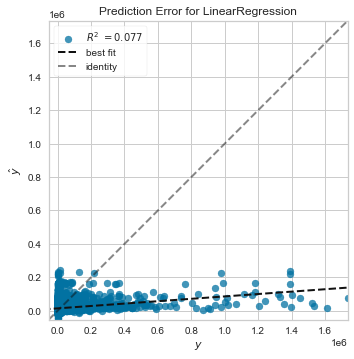

<AxesSubplot:title={'center':'Prediction Error for LinearRegression'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [59]:
from yellowbrick.regressor import PredictionError
visualizer = PredictionError(lm)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

#### 2. Decision Tree Regressor

In [60]:
from sklearn.tree import DecisionTreeRegressor

dt_reg = DecisionTreeRegressor() 

dt_reg.fit(X_train, y_train)

test_pred = dt_reg.predict(X_test)
train_pred = dt_reg.predict(X_train)
val_pred = dt_reg.predict(X_val)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)

print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

print('Validation set evaluation:\n_____________________________________')
print_evaluate(y_val, val_pred)

results_val_df_2 = pd.DataFrame(data=[["Decision Tree Regressor", *evaluate(y_val, val_pred), cross_val(DecisionTreeRegressor())]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', 'Cross Validation'])

results_train_df_2 = pd.DataFrame(data=[["Decision Tree Regressor", *evaluate(y_train, train_pred), cross_val(DecisionTreeRegressor())]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', 'Cross Validation'])

results_df_2 = pd.DataFrame(data=[["Decision Tree Regressor", *evaluate(y_test, test_pred), cross_val(DecisionTreeRegressor())]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', 'Cross Validation'])
results_df = results_df.append(results_df_2, ignore_index=True)
results_train_df = results_train_df.append(results_train_df_2, ignore_index=True)
results_val_df = results_val_df.append(results_val_df_2, ignore_index=True)

Test set evaluation:
_____________________________________
MAE: 27923.83330812113
MSE: 13040289781.221264
RMSE: 114194.08820609438
R2 Square -1.0746450170018886
__________________________________
Train set evaluation:
_____________________________________
MAE: 722.6758722287593
MSE: 141029312.4746012
RMSE: 11875.576300735944
R2 Square 0.9830430419266681
__________________________________
Validation set evaluation:
_____________________________________
MAE: 29732.063216096598
MSE: 18850982874.27671
RMSE: 137298.88154779962
R2 Square -1.437082884267317
__________________________________


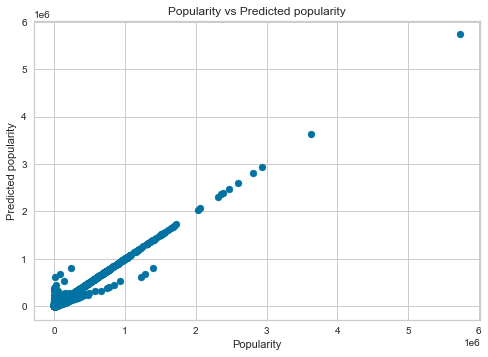

In [61]:
# TRAIN: Visualizing the differences between actual prices and predicted values
plt.scatter(y_train, train_pred)
plt.xlabel("Popularity")
plt.ylabel("Predicted popularity")
plt.title("Popularity vs Predicted popularity")
plt.show()

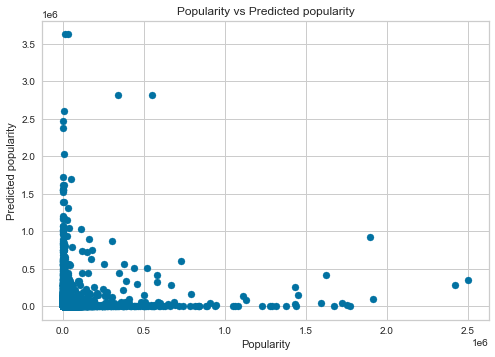

In [62]:
# VAL: Visualizing the differences between actual prices and predicted values
plt.scatter(y_val, val_pred)
plt.xlabel("Popularity")
plt.ylabel("Predicted popularity")
plt.title("Popularity vs Predicted popularity")
plt.show()

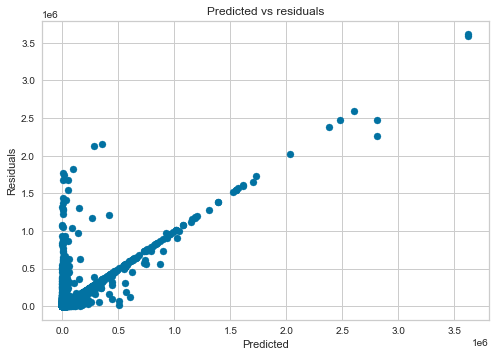

In [63]:
# Checking residuals
plt.scatter(val_pred,np.abs(y_val-val_pred))
plt.title("Predicted vs residuals")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.show()

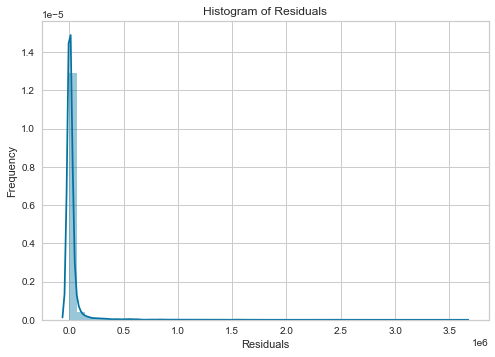

In [64]:
# Checking Normality of errors
sns.distplot(np.abs(y_val-val_pred))
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

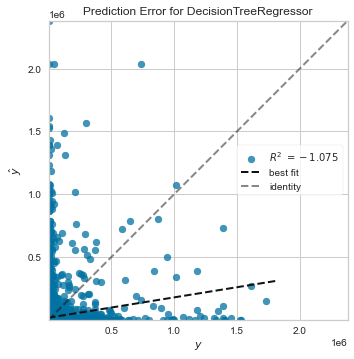

<AxesSubplot:title={'center':'Prediction Error for DecisionTreeRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [65]:
from yellowbrick.regressor import PredictionError
visualizer = PredictionError(dt_reg)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

In [66]:
results_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,22336.189666,5.798866e+09,76150.285335,0.077429,0.055633
1,Decision Tree Regressor,27923.833308,1.304029e+10,114194.088206,-1.074645,-1.236181


In [67]:
results_train_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,22814.022418,7.867413e+09,88698.436623,0.054045,0.055633
1,Decision Tree Regressor,722.675872,1.410293e+08,11875.576301,0.983043,-1.156234


In [68]:
results_val_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,23063.239970,7.349734e+09,85730.589243,0.049816,0.055633
1,Decision Tree Regressor,29732.063216,1.885098e+10,137298.881548,-1.437083,-1.095921
